In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, f1_score, \
    classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mglearn

# Metrics for Binary Classification

 * For **binary** classification, we often speak of a **positive class** and a **negative class**, with the understanding that the positive class is the one we are looking for.
 * Often, accuracy is not a good measure of predictive performance. Consider this: Let us assume 99% of emails are real and 1% is spam. If we create a model which predicts the emails to be 100% real we would essentially get 99% accurate model, which is in this case would be useless for us since it does not predict any spam emails.
 
**Logistic Regression Demo**

In [2]:
# data where target is number 9
digits = datasets.load_digits()

X = digits.data
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# init, train, predict
logi_reg = LogisticRegression(C=0.1, solver='liblinear').fit(X_train, y_train)
y_pred = logi_reg.predict(X_test)
print("Logistic Regression accuracy: {:.3f}".format(logi_reg.score(X_test, y_test)))

Logistic Regression accuracy: 0.978


Let’s inspect the predictions of LogisticRegression using the confusion_matrix function.

In [15]:
# confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[401   2]
 [  8  39]]


## Confusion matrix

The output of binary classification confusion_matrix is a two-by-two array, where the rows correspond to the true classes and the columns correspond to the predicted classes. Each entry counts how often a sample that belongs to the class corresponding to the row (here, “not nine” and “nine”) was classified as the class corresponding to the column. The following plot illustrates this meaning:

<img src="img/conf.png" alt="Drawing" style="width: 400px;"/>

Entries on the main diagonal of the confusion matrix correspond to correct classifications, while other entries tell us how many samples of one class got mistakenly classified as another class. 

If we declare “a nine” the positive class, we can relate the entries of the confusion matrix with the terms false positive and false negative. To complete the picture, we call correctly classified samples belonging to the positive class true positives and correctly classified samples belonging to the negative class true negatives. These terms are usually abbreviated FP, FN, TP, and TN and lead to the following interpretation for the confusion matrix:

<img src="img/conf2.png" alt="Drawing" style="width: 400px;"/>

Confusion matrices help determining which model classifies better.

## Accuracy

We know that accuracy is the number of correct predictions (TP and TN) divided by the number of all samples:

$$\text{Accuracy} = \frac{TP+TN}{TP+TN+FP+FN}$$

## Precision

 * Precision measures how many of the samples predicted as positive are actually positive:
 
 $$\text{Precision} = \frac{TP}{TP+FP} $$
 <br>
 * Used as a performance metric when the goal is to **limit** the number of **false positives**.
 * Precision is also known as positive predictive value (PPV).
 
## Recall

 * Measures how many of the positive samples are captured by the positive predictions:
 
 $$\text{Recall} = \frac{TP}{TP+FN} $$
 <br>
 * Used as performance metric when it is important to avoid false negatives.
 * Other names for recall are sensitivity, hit rate, or true positive rate (TPR)
 
**NB!** In the machine learning community, precision and recall are arguably the most commonly used
measures for binary classification, but other communities might use other related metrics.

There is a trade-off between optimizing recall and optimizing precision. while precision and recall are very important measures, looking at only one of them will not provide you with the full picture. 

## f1-score

 * One way to summarize them is the **f-score** or f-measure, which is with the harmonic mean of precision and recall:
 
 $$ \text{F}_1 = 2 \cdot \frac{\text{precision}\cdot \text{recall}}{\text{precision}+\text{recall}}$$
<br>
* The $F_1$ score favors classifiers that have similar precision and recall.

Let’s run it on the predictions for the “nine vs. rest” dataset that we computed earlier. Here, we will assume that the “nine” class is the positive class (it is labeled as True while the rest is labeled as False ), so the positive class is the minority class:

In [17]:
print("f1 score logistic regression: {:.3f}".format(f1_score(y_test, y_pred)))

f1 score logistic regression: 0.886


 * A disadvantage of the f-score, however, is that it is harder to interpret and explain than accuracy.

## Precision-Recall Tradeoff

* For each instance, classifier computes a score based on a `decision function`
* if `decision function` score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class.
* image below brings an example about different threshold values from digit recognition classifier, classifier detects 'not fives' and 'fives'


<img src="img/precrec.png" alt="Drawing" style="width: 600px;"/>

* increasing thrshold increases precision but lowers recall
* we cannot set threshold directly in **sklearn** but have access to decision scores which clssifier uses to make predicitons
* we can set a threshold mask on these decision function values 

In [3]:
print('Last 5 y_test true values (True == 9):\n{}'.format(y_test[-5:]))

threshold=0
y_score_9 = logi_reg.decision_function(X_test[-5:])
y_pred_9 = (y_score_9 > threshold)
print('\nLast 5 predicted values (threshold = 0):\n{}'.format(y_pred_9))

threshold = 2000
y_pred_9 = (y_score_9 > threshold)
print('\nLast 5 predicted values (threshold = 2000):\n{}'.format(y_pred_9))

Last 5 y_test true values (True == 9):
[False False False False  True]

Last 5 predicted values (threshold = 0):
[False False False False  True]

Last 5 predicted values (threshold = 2000):
[False False False False False]


* This confirms that raising the threshold decreases recall
* How to determine which thresholds to use?
* Need to get decision_function scores for all instances in the training_set using `cross_val_predict`

In [4]:
# create cross_val_predict for 9-detector training set
y_scores_9 = cross_val_predict(logi_reg, X_train, y_train, cv=3, 
                               method='decision_function')

# compute precision and recall for all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_9)

* Plot the precision and recall as a function of threshold value

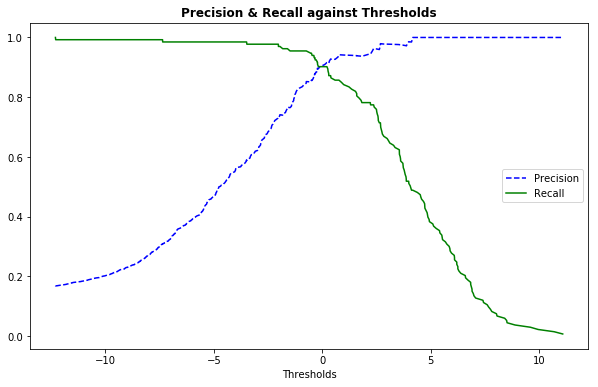

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
plt.plot(thresholds, recalls[:-1], "g-", label='Recall')
plt.title('Precision & Recall against Thresholds', weight='bold')
plt.xlabel('Thresholds')
plt.legend(loc='center right')
plt.show()

* from the plot we can find the threshold value we need to set in order to achieve preferred precision pr recall.
* another way, we can plot precision against recall

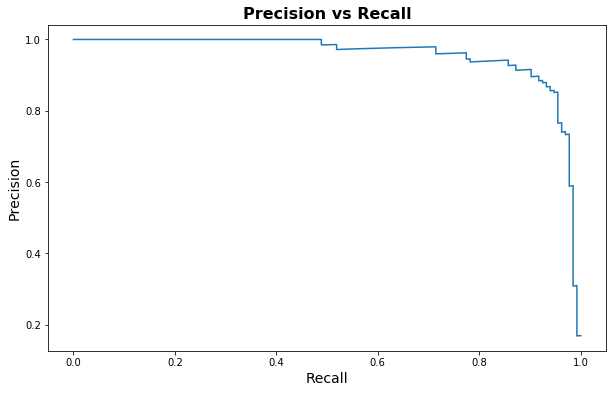

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision vs Recall', weight='bold', fontsize=16)
plt.show()

* let's assume we'd like to achive at minimum 90% precision, we would then select it on this plot

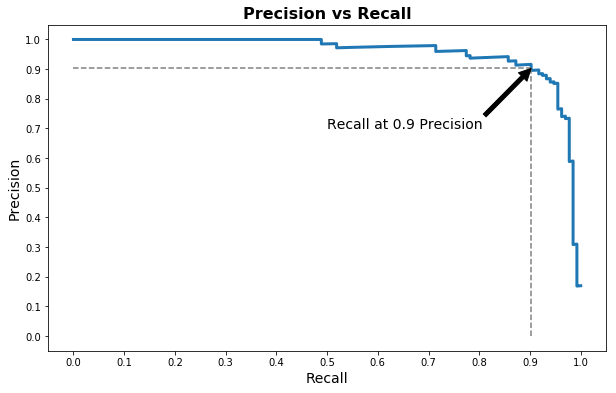

In [24]:
prec_90_arg = np.argwhere(precisions > 0.9)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, lw=3)
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision vs Recall', weight='bold', fontsize=16)
plt.plot([0, recalls[prec_90_arg]], [precisions[prec_90_arg], precisions[prec_90_arg]], c='gray', ls='--')
plt.plot([recalls[prec_90_arg], recalls[prec_90_arg]], [0, precisions[prec_90_arg]], c='gray', ls='--')
plt.annotate(s='Recall at 0.9 Precision', xytext=(0.5, 0.7),
             xy=(precisions[prec_90_arg], recalls[prec_90_arg]),
             arrowprops={'color':'k'}, fontsize=14)
plt.show()

## Classification Report
 * If we want a more comprehensive summary of precision, recall, and f 1 -score, we can use the classification_report convenience function to compute all three at once, and print them in a nice format:

In [19]:
print(classification_report(y_true=y_test, y_pred=y_pred, target_names=['not nine', 'nine']))

              precision    recall  f1-score   support

    not nine       0.98      1.00      0.99       403
        nine       0.95      0.83      0.89        47

   micro avg       0.98      0.98      0.98       450
   macro avg       0.97      0.91      0.94       450
weighted avg       0.98      0.98      0.98       450



 * Setting a requirement on a classifier like 90% recall is often called setting the operating point. Fixing an operating point is often helpful in business settings to make performance guarantees to customers or other groups inside your organization.
 * Often, when developing a new model, it is not entirely clear what the operating point will be. For this reason, and to understand a modeling problem better, it is instructive to look at all possible thresholds, or all possible trade-offs of precision and recalls at once.

## ROC (Receiver Operating Characteristics) Curve

 * Visual evaluation of models contrary to confusion matrix and classification report.
 * Used to analyze the behavior of classifiers at different thresholds.
 * ROC curve considers all possible thresholds for a given classifier, it shows the false positive rate (FPR) against the true positive rate (TPR).
 * TPR == Recall
 * The false positive rate is the fraction of false positives out of all negative samples:
 $$\text{FPR} = \frac{FP}{FP+TN}$$
 <br>

In [26]:
# import diabetes data
diab = pd.read_csv('data/diabetes.csv', header=0)
diab.head(2)

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


In [28]:
# data
X = diab.drop('diabetes', axis=1)
y = diab.diabetes

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# init, fit, predict probabilities
logi_reg = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_pred_proba = logi_reg.predict_proba(X_test)
y_pred_proba[:2,] 

array([[0.6631067 , 0.3368933 ],
       [0.77597349, 0.22402651]])

The classifier outputs a probability matrix of dimension (N,2). The first index refers to the probability that the data belong to class 0, and the second refers to the probability that the data belong to class 1. These two would sum to 1.

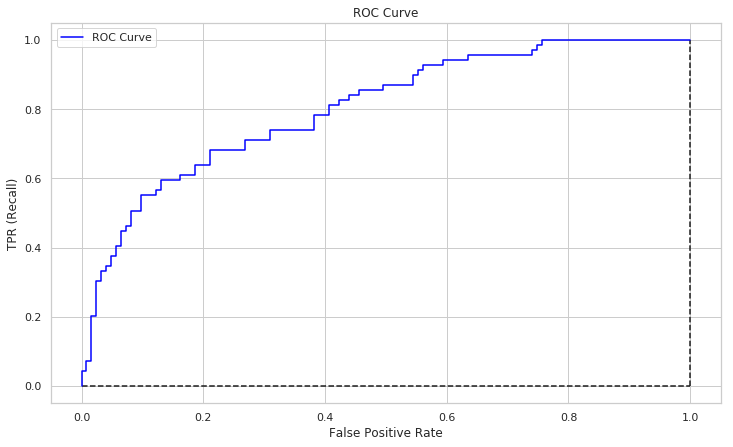

In [95]:
# extract probabilities that the patient has diabetes
y_pred_prob = y_pred_proba[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

'''fpr - Increasing false positive rates such that element i 
       is the false positive rate of predictions with score >= thresholds[i].

tpr - Increasing true positive rates such that element i 
       is the true positive rate of predictions with score >= thresholds[i].

thresholds - Increasing true positive rates such that element i 
              is the true positive rate of predictions with score >= thresholds[i].'''

# Plot ROC curve
sns.set(style='whitegrid')
plt.figure(figsize=[12,7])
plt.plot([0, 1], [0, 0], 'k--')
plt.plot([1, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('TPR (Recall)')
plt.legend()
plt.title('ROC Curve')
plt.show()

**The ideal curve is close to the top left: you want a classifier that produces a high recall while keeping a low false positive rate. Depending on the problem at hand this may vary.**

* The ROC curve is similar to the Precision-Recall (PR) curve
* Which one to use?
* Opt for PR:
    * whenever the positive class is rare
    * when you care more about the false positives than the false negatives
* Opt for ROC otherwise

## AUC (Area Under ROC Curve)

 * We often want to summarize the ROC curve using single number, the area under the curve.

In [77]:
logi_reg_auc = roc_auc_score(y_test, logi_reg.predict_proba(X_test)[:,1])

print("Logistic Regression AUC: {:.3f}".format(logi_reg_auc))

Logistic Regression AUC: 0.803


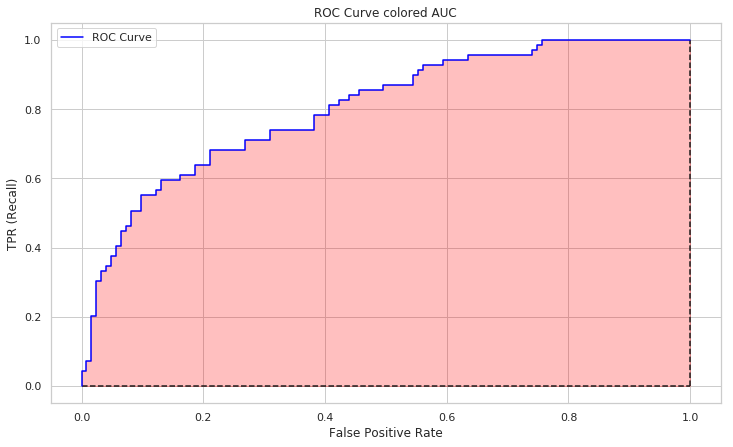

In [98]:
# Plot ROC curve with AUC colored
sns.set(style='whitegrid')
plt.figure(figsize=[12,7])
plt.plot([0, 1], [0, 0], 'k--')
plt.plot([1, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.fill_between(fpr, tpr, alpha=0.25, color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('TPR (Recall)')
plt.legend()
plt.title('ROC Curve colored AUC')
plt.show()

 * Recall that because average precision is the area under a curve that goes from 0 to 1, average precision always returns a value between 0 (worst) and 1 (best). Predicting randomly always produces an AUC of 0.5, no matter how imbalanced the classes in a dataset are. This makes AUC a much better metric for imbalanced classification problems than accuracy.
 * If the AUC is greater than 0.5, the model is better than random guessing.

# Uncertainty Estimates

 * Two functions to obtain uncertainty estimates from classifiers: **decision_function** and **predict_proba**.
 * Most classifiers have one of them, some has both.

Example on GradientBoostingClassifier, which has both estimate functions

In [12]:
# use synthetic data
X, y = datasets.make_circles(noise=0.25, factor=0.5, random_state=1)

# rename the classes "blue" and "red" for illustration purposes
y_named = np.array(["blue", "red"])[y]

# we can call train_test_split with arbitrarily many arrays;
# all will be split in a consistent manner
X_train, X_test, y_train_named, y_test_named, y_train, y_test = \
train_test_split(X, y_named, y, random_state=0)

# build the gradient boosting model
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

## The Decision Function

 * In the binary classification case, the return value of decision_function is of shape (n_samples,)
 * it returns one floating-point number for each sample:

In [13]:
print('X_test.shape: {}'.format(X_test.shape))
print('Decision function shape: {}'.format(gbrt.decision_function(X_test).shape))

X_test.shape: (25, 2)
Decision function shape: (25,)


 * This value encodes how strongly the model believes a data point to belong to the “positive” class, in this case class 1. 
 * Positive values indicate a preference for the positive class,
 * negative values indicate a preference for the “negative” (other) class.
 * For binary classification, the “negative” class is always the first entry of the classes_ attribute.
 * the “positive” class is the second entry of classes_.

In [25]:
# show the first few entries of decision_function
print('Decision function:\n{}'.format(np.array([round(i, 3) for i in gbrt.decision_function(X_test)[:6]])))

# we can encode entries by sign and recover model predicitons
print("\nIs red:\n{}".format((gbrt.decision_function(X_test) > 0)[:6]))

# printing predicitons
print("\nPredictions:\n{}".format(gbrt.predict(X_test)[:6]))

Decision function:
[ 4.136 -1.702 -3.951 -3.626  4.29   3.662]

Is red:
[ True False False False  True  True]

Predictions:
['red' 'blue' 'blue' 'blue' 'red' 'red']


The range of decision_function can be arbitrary, and depends on the data and the model parameters:

In [31]:
dec_func = gbrt.decision_function(X_test)
print("Decision function minimum: {:.2f}\nDecision function maximum: {:.2f}".format(np.min(dec_func), 
                                                                  np.max(dec_func)))

Decision function minimum: -7.69
Decision function maximum: 4.29


 * This arbitrary scaling makes the output of decision_function often hard to interpret.

## Predicting Probabilities

 * The output of predict_proba is a probability for each class, and is often more easily understood than the output of decision_function.
 * It is always of shape (n_samples, 2) for binary classification:

In [35]:
print("Shape of probabilities: {}".format(gbrt.predict_proba(X_test).shape))

Shape of probabilities: (25, 2)


 * The first entry in each row is the estimated probability of the first class
 * the second entry is the estimated probability of the second class. 
 * The output of predict_proba is always between 0 and 1.
 * The sum of the entries for both classes is always 1.

In [44]:
# show the first few entries of predict_proba
print('Predicted probabilities:\n\n{}'.format(np.array( \
    [[round(i[0], 3), round(i[1], 3)] for i in gbrt.predict_proba(X_test)[:6]])))

Predicted probabilities:

[[0.016 0.984]
 [0.846 0.154]
 [0.981 0.019]
 [0.974 0.026]
 [0.014 0.986]
 [0.025 0.975]]


 * the classifier is relatively certain for most points.
 * Because the probabilities are floating point numbers, almost always one class exceeds 50% certainty. That class will be predicted.
 * If the certainty would be equal, the class is chosen at random!
 * A model that is more overfitted tends to make more certain predictions, even if they might be wrong.
 * A model with less complexity usually has more uncertainty in its predictions.
 * A model is called calibrated if the reported uncertainty actually matches how correct it is—in a calibrated model, a prediction made with 70% certainty would be correct 70% of the time.

# Metrics for Multiclass Classification

* Most of the metrics that apply for binary case do apply for multiclass case as well.

## Confusion Matrix

1. Extract best parameters with GridSearchCV
2. Measure best model generalization accuracy
3. Construct confusion matrix with best params

In [6]:
# 1. Finding best parameters
digits = datasets.load_digits()
X = digits.data
y = digits.target

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=1)

C_space = np.logspace(-5, 5, 10)

param_grid = {'C':C_space, 'penalty':['l1', 'l2']}

clf = LogisticRegression(solver='liblinear', multi_class='auto')
clf_cv = GridSearchCV(clf, param_grid=param_grid, cv=5,
                     iid=False, return_train_score=False).fit(X_train, y_train)

print("Best parameters: {}".format(clf_cv.best_params_))

Best parameters: {'C': 0.2782559402207126, 'penalty': 'l1'}


In [9]:
# 2. Rebuild the model with optimum paramters
clf_opted = LogisticRegression(**clf_cv.best_params_, solver='liblinear',
                              multi_class='auto').fit(X_trainval, y_trainval)

y_pred = clf_opted.predict(X_test)

print('Accuracy: {:.3f}'.format(clf_opted.score(X_test, y_test)))
print('Confusion matrix:\n{}'.format(confusion_matrix(y_test, y_pred)))

Accuracy: 0.953
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  1  0  2  0]
 [ 0  0 43  1  0  0  0  0  0  0]
 [ 0  0  0 43  0  0  0  0  1  1]
 [ 0  0  0  0 37  0  0  1  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  1  0  0  0  0 51  0  0  0]
 [ 0  1  0  0  1  0  0 46  0  0]
 [ 0  3  1  0  0  1  0  0 43  0]
 [ 0  0  0  1  0  1  0  0  3 42]]


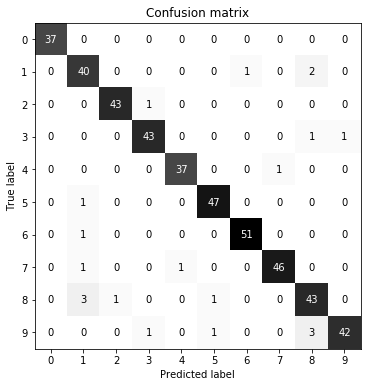

In [13]:
# visually more appealing:
plt.figure(figsize=(6,6))
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, y_pred), xlabel='Predicted label',
    ylabel='True label', xticklabels=digits.target_names,
    yticklabels=digits.target_names, cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()
plt.show()

* For the first class (number 0) all 37 entries were correctly predicted. (All 0s in top row))
* No other classes (numbers) were mistakenly classified as 0. (All 0s in first column)
* The digit 8 was three times mistakenly labeld as digit 1

## Uncertainty in Multiclass Classification

### Classification Report
Explore this on iris dataset, which has 3 classes:

In [64]:
iris = datasets.load_iris()

X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0).fit(X_train, y_train)

decision_func = gbrt.decision_function(X_test)
dec_vals = np.array([[round(i, 2) for i in j] for j in decision_func[:6, :]])

# print decision functions
print("Decision function:\n{}".format(dec_vals))

# print predicitons
print("\nMaximum scores:\n{}".format(np.argmax(decision_func[:6, :], axis=1)))

Decision function:
[[-0.53  1.47 -0.5 ]
 [ 1.51 -0.5  -0.5 ]
 [-0.52 -0.47  1.52]
 [-0.53  1.47 -0.5 ]
 [-0.53  1.28  0.22]
 [ 1.51 -0.5  -0.5 ]]

Maximum scores:
[1 0 2 1 1 0]


In [65]:
# predicted probabilities
probs = np.array([[round(i, 3) for i in j] for j in gbrt.predict_proba(X_test)[:6, :]])
print("Probabilities:\n{}".format(probs))

Probabilities:
[[0.107 0.784 0.109]
 [0.789 0.106 0.105]
 [0.102 0.108 0.789]
 [0.107 0.784 0.109]
 [0.108 0.663 0.228]
 [0.789 0.106 0.105]]


In [14]:
print('Classification report\n')
print(classification_report(y_test, y_pred))

Classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.87      0.93      0.90        43
           2       0.98      0.98      0.98        44
           3       0.96      0.96      0.96        45
           4       0.97      0.97      0.97        38
           5       0.96      0.98      0.97        48
           6       0.98      0.98      0.98        52
           7       0.98      0.96      0.97        48
           8       0.88      0.90      0.89        48
           9       0.98      0.89      0.93        47

   micro avg       0.95      0.95      0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450

